In [118]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import torch

from camera_calib_python.modules import *

# Image file name parsing

This will parse camera# and pose# from image file names so we can construct the coordinate graph

In [119]:
dir_data = Path('data')

In [120]:
files_img = list(dir_data.rglob('*.png'))
files_img

[PosixPath('data/SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/SERIAL_16276942_DATETIME_2019-06-07-00:38:19-438636_CAM_3_FRAMEID_0_COUNTER_1.png'),
 PosixPath('data/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png'),
 PosixPath('data/SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1.png')]

In [121]:
def _parse_name(name_img):
    match = re.match(r"""SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png""", 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [122]:
def _parse_cam_and_pos(name_img):
    dict_group = _parse_name(name_img)
    return {'cam': dict_group['cam'],
            'pos': dict_group['counter']}

In [123]:
cam_and_poss = [_parse_cam_and_pos(file_img.name) for file_img in files_img]
cam_and_poss

[{'cam': '2', 'pos': '2'},
 {'cam': '1', 'pos': '1'},
 {'cam': '3', 'pos': '1'},
 {'cam': '3', 'pos': '2'},
 {'cam': '2', 'pos': '1'}]

In [124]:
cams = sorted({cam_and_pos['cam'] for cam_and_pos in cam_and_poss}, key=float)
cams

['1', '2', '3']

In [125]:
poss = sorted({cam_and_pos['pos'] for cam_and_pos in cam_and_poss}, key=float)
poss

['1', '2']

# Coordinate graph

Some things:

* I  think this should be a digraph, with each edge containing a tranform and the opposite edge containing the inverse transform; if a transform is not inversible then it should only contain a single edge
* The nodes are just 3D coordinate systems; the path from one node to another will contain edges with transforms; if these transforms are composed they should yeild the transform to convert coordinates from node1 to node2
* I'm using `networkx` to represent the digraph

### Node stuff

In [126]:
class Node:
    def __init__(self, label):
        self.label = label
        
    def __repr__(self):
        return f'{self.__class__.__name__}({self.label})'

In [127]:
class CamNode(Node):
    def __init__(self, label):
        super().__init__(label)

In [128]:
class PosNode(Node):
    def __init__(self, label):
        super().__init__(label)

In [129]:
nodes_cam = {cam: CamNode(cam) for cam in cams}
nodes_cam

{'1': CamNode(1), '2': CamNode(2), '3': CamNode(3)}

In [130]:
nodes_pos = {pos: PosNode(pos) for pos in poss}
nodes_pos

{'1': PosNode(1), '2': PosNode(2)}

### test graph

In [131]:
def _rand_rigid():
    return Rigid(R=euler2R(*torch.rand(3)), t=torch.rand(3))

In [132]:
G = nx.DiGraph()

In [133]:
for cam_and_pos in cam_and_poss:
    cam, pos = cam_and_pos['cam'], cam_and_pos['pos']
    node_cam, node_pos = nodes_cam[cam], nodes_pos[pos]
    G.add_edge(node_cam, node_pos)
    G.add_edge(node_pos, node_cam)

In [134]:
{node_cam: (0, y) for node_cam,y in zip(nodes_cam.values(), 
                                                     torch.linspace(0, 1, len(nodes_cam)))}

{CamNode(1): (0, tensor(0.)),
 CamNode(2): (0, tensor(0.5000)),
 CamNode(3): (0, tensor(1.))}

In [135]:
def draw_bipartite(G, nodes_cam, nodes_pos):
    def _get_p(nodes, x):
        return {node: (x, y) for node,y in zip(nodes.values(), torch.linspace(0, 1, len(nodes)))}

    nx.draw(G, 
            node_color=['g' if isinstance(node, CamNode) else 'r' for node in G], 
            pos={**_get_p(nodes_cam, 0), 
                 **_get_p(nodes_pos, 1)}, 
            with_labels=True)
    plt.xlim(-0.5, 1.5);
    plt.ylim(-0.5, 1.5);

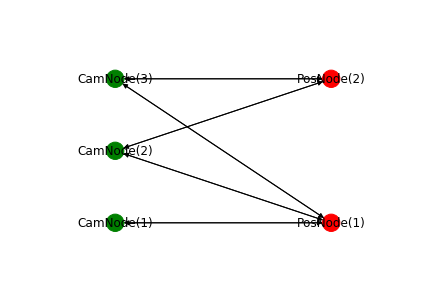

In [136]:
draw_bipartite(G, nodes_cam, nodes_pos)

In [ ]:
# Do initial guess for each 

In [ ]:
def _insert(graph, node1, node2):
    if node1 in graph:
        graph[node1].append(node2)
    else:
        graph[node1] = [node2]

In [72]:
def _add_edge(graph, node1, node2):
    _insert(graph, node1, node2)
    _insert(graph, node2, node1)

In [73]:
graph = {}
for cam_and_pos in cam_and_poss:
    node_cam = nodes_cam[cam_and_pos['cam']]
    node_pos = nodes_pos[cam_and_pos['pos']]
    _add_edge(graph, node_cam, node_pos)

In [74]:
graph

{CamNode(16276941): [PosNode(2), PosNode(1)],
 PosNode(2): [CamNode(16276941), CamNode(16276942)],
 CamNode(19061245): [PosNode(1)],
 PosNode(1): [CamNode(19061245), CamNode(16276942), CamNode(16276941)],
 CamNode(16276942): [PosNode(1), PosNode(2)]}

Do BFS to get Pose spanning tree

In [164]:
def bfs(graph, node_root):         
    queue   = []
    visited = dict.fromkeys(graph.keys(), False)
    
    def _add_queue(node_curr, node_prnt):
        queue.append([node_curr, node_prnt])
        visited[node_curr] = True
    
    _add_queue(node_root, None) # Root node has no parent
    while queue:
        node_curr, node_prnt = queue.pop(0)
        yield node_curr, node_prnt # Return current node and its parent
        for node_nebr in graph[node_curr]:
            if not visited[node_nebr]:               
                _add_queue(node_nebr, node_curr)
    
    if not np.all(np.array(list(visited.values()))):
        raise RuntimeError('Graph is disjoint!')

In [165]:
node_root = nodes_cam['19061245']
for node_curr, node_prnt in bfs(graph, node_root):
    print(node_curr, node_prnt)

CamNode(19061245) None
PosNode(1) CamNode(19061245)
CamNode(16276942) PosNode(1)
CamNode(16276941) PosNode(1)
PosNode(2) CamNode(16276942)


In [148]:
{'1','2'}

{'1', '2'}

In [149]:
{'2','1'}

{'1', '2'}

In [151]:
a = {}
a[{'2','1'}] = 'test'

TypeError: unhashable type: 'set'

In [167]:
import networkx as nx
G=nx.Graph()
G.add_edge(1,2, test=5)
G.get_edge_data(1,2)

{'test': 5}

In [171]:
G.get_edge_data??

In [170]:
G._adj

{1: {2: {'test': 5}}, 2: {1: {'test': 5}}}

In [172]:
G.add_edge??